In [106]:
import casadi as ca
import control
import numpy as np
import sys
sys.path.insert(0, '../python/pyecca')
import pyecca
import pyecca.lie.so3 as so3
from pyecca.util import rk4
import matplotlib.pyplot as plt

In [107]:
def equations():
    # ECI

    # x: state
    p_t = ca.SX.sym('p_t', 3) # target
    v_t = ca.SX.sym('v_t', 3)
    r_t = ca.SX.sym('r_t', 4)
    w_t = ca.SX.sym('w_t', 3)

    p_c = ca.SX.sym('p_c', 3) # chaser
    v_c = ca.SX.sym('v_c', 3)
    r_c = ca.SX.sym('r_c', 4)
    w_c = ca.SX.sym('w_c', 3)

    x = ca.vertcat(p_t, v_t, r_t, w_t, p_c, v_c, r_c, w_c)

    # u: input
    thrust = ca.SX.sym('thrust', 6)
    u = ca.vertcat(thrust)

    # p: parameters
    G = ca.SX.sym('G')
    m_e = ca.SX.sym('m_e')
    m_t = ca.SX.sym('m_t')
    m_c = ca.SX.sym('m_c')
    J_x = ca.SX.sym('J_x')
    J_y = ca.SX.sym('J_y')
    J_z = ca.SX.sym('J_z')
    p = ca.vertcat(G, m_e, m_t, m_c, J_x, J_y, J_z)
    name_p = ['G', 'm_e', 'm_t', 'm_c', 'J_x', 'J_y', 'J_z']
    id_p = {n: i for i, n in enumerate(name_p)}

    # prep variables
    p_e = ca.SX.zeros(3)  # earth centered, so zero vector
    J = ca.diag(ca.vertcat(J_x, J_y, J_z))

    # Forces
    def force_gravity_on_1(G, m1, m2, p1, p2):
        r = ca.norm_2(p2 - p1)
        return G*m1*m2/r**3*(p2 - p1)

    # assume earth does not move
    # assume mass does not change
    # no external torques on target

    F_t = force_gravity_on_1(G, m_t, m_c, p_t, p_c) + force_gravity_on_1(G, m_t, m_e, p_t, p_e)
    F_c = force_gravity_on_1(G, m_c, m_t, p_c, p_t) + force_gravity_on_1(G, m_c, m_e, p_c, p_e)

    a_c = (F_c + u[:3])/m_c
    a_t = F_t/m_t

    alpha_c = ca.mtimes(ca.inv(J), thrust[3:])
    alpha_t = ca.mtimes(ca.inv(J), ca.SX.zeros(3))

    #x = ca.vertcat(p_t, v_t, r_t, w_t, p_c, v_c, r_c, w_c)

    name_x = ['p_tx', 'p_ty', 'p_tz', 'v_tx', 'v_ty', 'v_tz',
               'r_t0', 'r_t1', 'r_t2', 'r_t3',
               'w_t0', 'w_t1', 'w_t2',
               'p_cx', 'p_cy', 'p_cz', 'v_cx', 'v_cy', 'v_cz',
               'r_c0', 'r_c1', 'r_c2', 'r_c3',
               'w_c0', 'w_c1', 'w_c2'
              ]
    id_x = {n: i for i, n in enumerate(name_x)}
    
    x_dot = ca.vertcat(
        v_t, a_t, so3.Mrp.kinematics(r_t, w_t), alpha_t,
        v_c, a_c, so3.Mrp.kinematics(r_c, w_c), alpha_c)
    chi = so3.Mrp.log(so3.Mrp.product(so3.Mrp.inv(r_c), r_t))
    y = ca.vertcat(p_c - p_t, v_c - v_t, chi, w_c - w_t)

    name_u = ['f_cx', 'f_cy', 'f_cz', 'm_cx', 'm_cy', 'm_cz']
    id_u = {n: i for i, n in enumerate(name_u)}

    name_y = ['p_ex', 'p_ey', 'p_ez', 'v_ex', 'v_ey', 'v_ez', 'chi_x', 'chi_y', 'chi_z', 'w_ex', 'w_ey', 'w_ez']
    id_y = {n: i for i, n in enumerate(name_y)}

    rhs = ca.Function('rhs', [x, u, p], [x_dot], ['x', 'u', 'p'], ['x_dot'])
    
    measure = ca.Function('y', [x, u, p], [y], ['x', 'u', 'p'], ['y'])
    
    return {
        'x': x,
        'u': u,
        'p': p,
        'y': y,
        'x_dot': x_dot,
        'name_x': name_x,
        'id_x': id_x,
        'name_y': name_y,
        'id_y': id_y,
        'name_p': name_p,
        'id_p': id_p,
        'name_u': name_u,
        'id_u': id_u,
        'rhs': rhs,
        'measure': measure
    }

def linearize_symbolic(eqs):
    x_dot = eqs['x_dot']
    x = eqs['x']
    u = eqs['u']
    y = eqs['y']
    p = eqs['p']
    
    A = ca.jacobian(x_dot, x)
    B = ca.jacobian(x_dot, u)
    C = ca.jacobian(y, x)
    D = ca.jacobian(y, u)
    
    s = ca.SX.sym('s')
    n = A.shape[0]
    G = ca.mtimes([C, ca.inv(s*ca.SX.eye(n) - A), B]) + D
    return A, B, C, D, G

def linearize(eqs, x0, u0, p0):
    x_dot = eqs['x_dot']
    x = eqs['x']
    u = eqs['u']
    y = eqs['y']
    p = eqs['p']
    
    A = ca.jacobian(x_dot, x)
    B = ca.jacobian(x_dot, u)
    C = ca.jacobian(y, x)
    D = ca.jacobian(y, u)

    f_ss = ca.Function('ss', (x, u, p), (A, B, C, D))
    sys = control.ss(*[np.array(ca.DM(m), dtype=np.float) for m in f_ss(x0, u0, p0)])
    return sys

In [98]:
def initialize(eqs):
    # p: G, m_e, m_t, m_c, J_x, J_y, J_z
    G = 6.67e-11
    r = 42e6
    m_e = 5.972e24
    m_t = 2.2e6
    m_c = 4200
    J_x = 1
    J_y = 1
    J_z = 1
    V_orbit = np.sqrt(G*m_e/r)


    id_x = eqs['id_x']

    x0 = ca.SX.zeros(26)
    x0[id_x['p_cx']] = r
    x0[id_x['p_cy']] = -1
    x0[id_x['v_cy']] = V_orbit

    x0[id_x['p_tx']] = r
    x0[id_x['p_ty']] = 0
    x0[id_x['v_ty']] = V_orbit

    u0 = ca.SX.zeros(6)
    # p: G, m_e, m_t, m_c, J_x, J_y, J_z
    p0 = ca.vertcat(G, m_e, m_t, m_c, J_x, J_y, J_z)

    return x0, u0, p0

In [99]:
def simulate(eqs, x0, u0, p0, dt, tf):
    x = x0
    data = {
        't': [],
        'x': [],
        'u': [],
        'y': []
    }
    t = ca.SX.sym('t')
    u = u0
    for t in np.arange(0, tf, dt):
        x_dot_val = eqs['rhs'](x, u0, p0)
        x = rk4(lambda t, x: eqs['rhs'](x, u0, p0), t, x, dt)
        u = u0# put controller here
        y = eqs['measure'](x, u0, p0)
        
        data['t'].append(t)
        data['x'].append(np.array(ca.DM(x)).reshape(-1))
        data['u'].append(np.array(ca.DM(u)).reshape(-1))
        data['y'].append(np.array(ca.DM(y)).reshape(-1))

    for key in data.keys():
        data[key] = np.array(data[key], dtype=np.float)
        
    return data

In [100]:
def analyze(eqs, data):
    plt.figure()
    plt.plot(data['x'][:, eqs['id_x']['p_cx']], data['x'][:, eqs['id_x']['p_cy']], label='chaser', linewidth=5)
    plt.plot(data['x'][:, eqs['id_x']['p_tx']], data['x'][:, eqs['id_x']['p_ty']],  label='target', linewidth=2)
    plt.legend()
    plt.grid()
    plt.axis('equal')
    
    plt.figure()
    plt.plot(data['y'][:, eqs['id_y']['p_ex']], data['y'][:, eqs['id_y']['p_ey']], '.', label='error')
    plt.plot(0, 0, 'rX', label='station')
    plt.legend()
    plt.grid()
    plt.axis('equal')

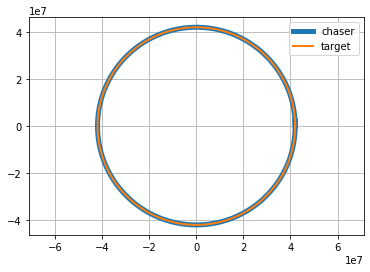

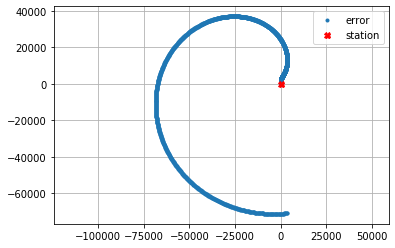

In [101]:
eqs = equations()
x0, u0, p0 = initialize(eqs)
sys = linearize(eqs, x0, u0, p0)
data = simulate(eqs, x0, u0, p0, dt=60, tf=3600*24)
analyze(eqs, data)

In [102]:
G = control.minreal(control.ss2tf(sys), 1e-2)
#control.rlocus(G, k_vect = np.linspace(0, 2))
G

142 states have been removed from the model



Input 1 to output 1:
  0.0002381
--------------
s^2 + 0.000147

Input 1 to output 2:
0
-
1

Input 1 to output 3:
0
-
1

Input 1 to output 4:
  0.0002381 s - 9.395e-21
----------------------------
s^2 - 4.337e-18 s + 0.000147

Input 1 to output 5:
                        -9.144e-20 s
-----------------------------------------------------------
s^4 - 4.337e-18 s^3 - 0.000147 s^2 - 2.55e-22 s - 4.323e-08

Input 1 to output 6:
0
-
1

Input 1 to output 7:
0
-
1

Input 1 to output 8:
0
-
1

Input 1 to output 9:
0
-
1

Input 1 to output 10:
0
-
1

Input 1 to output 11:
0
-
1

Input 1 to output 12:
0
-
1

Input 2 to output 1:
0
-
1

Input 2 to output 2:
          0.0002381
----------------------------
s^2 - 3.469e-18 s - 0.000294

Input 2 to output 3:
0
-
1

Input 2 to output 4:
                  -9.144e-20 s - 7.915e-38
------------------------------------------------------------
s^4 + 9.541e-18 s^3 - 0.000147 s^2 + 3.315e-21 s - 4.323e-08

Input 2 to output 5:
        0.0002381 s
-----------

In [103]:
G[eqs['id_y']['v_ex'], eqs['id_u']['f_cx']]


  0.0002381 s - 9.395e-21
----------------------------
s^2 - 4.337e-18 s + 0.000147

In [104]:
R = control.ctrb(sys.A, sys.B)
u, s, ht = np.linalg.svd(R)
np.set_printoptions(precision=2, linewidth=200)
np.round(u, 3)

array([[ 0.  , -0.  , -0.  , -0.  , -0.  , -0.  ,  0.  , -0.  , -0.  ,  0.  , -0.  ,  0.  , -0.  , -1.  ,  0.  ],
       [-0.  , -0.  , -0.  , -0.  , -0.  ,  0.  , -0.  ,  0.  , -0.  , -0.64,  0.77, -0.  ,  0.  , -0.  , -0.  ],
       [-0.  ,  0.  ,  0.  ,  0.  ,  0.  , -0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  , -0.01, -1.  ,  0.  ,  0.01],
       [-0.  , -0.  ,  0.  ,  0.  , -0.  , -0.  , -0.  , -0.  ,  0.  , -0.  , -0.  ,  0.78, -0.01, -0.  , -0.62],
       [-0.  , -0.  ,  0.  , -0.  ,  0.  ,  0.  , -0.  ,  0.  , -0.  , -0.77, -0.64, -0.  , -0.  , -0.  , -0.  ],
       [-0.  ,  0.  , -0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  , -0.62, -0.  , -0.  , -0.78],
       [ 0.  ,  0.  ,  0.  , -0.  , -0.  , -0.  , -0.  ,  0.  ,  1.  , -0.  ,  0.  ,  0.  , -0.  , -0.  ,  0.  ],
       [ 0.  , -0.  ,  0.  , -0.  ,  1.  ,  0.  , -0.  , -0.  ,  0.  , -0.  ,  0.  ,  0.  ,  0.  ,  0.  , -0.  ],
       [ 0.  , -0.  ,  0.  , -0.  , -0.  ,  0.48, -0.87, -0.  ,  0.  , -0.  , -0.  , -0.

In [105]:
np.linalg.matrix_rank(R, 1e-17)

15